/var/folders/95/2gtjccms72s2v7wsktz_j2r80000gn/T/ipykernel_50104/3737780872.py:133: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_ylim([-.1e8,.4e8])


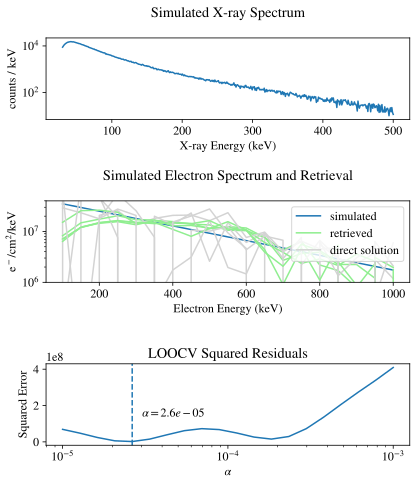

In [3]:
import numpy as np
from natsort import natsorted
from io import BytesIO
import matplotlib.pyplot as plt

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', size=12) 
%config InlineBackend.figure_format = 'svg'

# note - if you change settings - beam type, spectrum bin widths, etc, you will need to adjust the plot labels. 
# the value for alphja from the L-curve method, for example, is set by visually looking at that graph. 
# they do not update automatically.

np.random.seed(34242) # keep the random data the same over runs. Feel free to change this.

beam_type = 'iso' # use isotropic beam, other options are 'cos' for lambertian or 'beam1d' for pencil beam

# x-ray spectrum discretization. min is 30 keV, max is 1000 keV, min step is 10 keV
x_low_keV =  30   # around 30 keV works well and captures the low energy inflection point;
x_high_keV = 500  # should be left at around 500 keV, X-ray spectra do not usually extend farther
x_bin_keV =  1    # should be left at 1 keV. There is no benefit to coarser binning here and it makes the condition number worse.

# electron spectrum discretization. min is 70 keV, max is 2000 keV, min step is 10 keV
e_low_keV =  100   # suggest 100 keV
e_high_keV = 1000  # should be set to the lowest value you expect from your X-ray data
e_bin_keV =  50    # minimum 10 keV, step size is 10 keV. 

g4_response_data = np.load('/Users/patrick/Documents/phd/data/g4_response.zip')
response = []
file_names = []

# assemble the matrix which maps electron spectra to X-ray spectra by matrix multiplication
for file in natsorted(g4_response_data.files): # arranged by energy
  if (beam_type in file):                      # use the chosen beam type (iso, cos, or beam1d)
    file_names.append(file)
for i in range(int(e_low_keV/10), int((e_high_keV+10)/10), int(e_bin_keV/10)): # energies are sampled in multiples of 10 keV
  response.append(np.loadtxt(BytesIO(g4_response_data[file_names[i]]), dtype='float', delimiter=',', skiprows=9)[x_low_keV:x_high_keV:x_bin_keV,3]/5000000.0)
response = np.array(response).T

# make ranges for X-ray and electron spectrum energies
xspace = np.linspace(x_low_keV,x_high_keV,response.shape[0])
espace = np.linspace(e_low_keV,e_high_keV,response.shape[1])

right = []
for i in range(0, response.shape[1]):
  norm = np.linalg.norm(response[:,i])
  if (norm > 0):
    right.append(1.0/np.linalg.norm(response[:,i]))
  else: 
    right.append(1.0)
#right = np.diag(np.array(right))
right = np.identity(response.shape[1])

# simulate an exponential electron beam and the corresponding X-ray spectrum plus noise
beam_0 = np.exp(-espace/300.0)              # exponential electron beam, folding factor of 250 keV
beam_0 *= 1e10/np.trapz(beam_0,espace)       # total intensity is 1e10 electrons / cm^2 / sec
beam_0_signal = np.matmul(response, beam_0) # compute X-ray response from the electron beam
for e in range(0, len(xspace)):             # add some measurement noise. This is poisson in reality but use a normal distribution
  beam_0_signal[e] = np.random.normal(beam_0_signal[e], scale=np.sqrt(beam_0_signal[e]))

#  implement tikhonov regularization
def tk(response, alpha, x):
    R = np.matmul(response,right)                          # apply preconditioner
    I = np.identity(R.shape[1])
    C = np.matmul(np.transpose(R),R) + (alpha**2)*I        # normal equations provide explicit solution
    D = np.matmul(np.transpose(R), x)
    s = np.linalg.solve(C,D)
    sol = np.matmul(s, right)
    error = np.linalg.norm(np.matmul(R,sol) - x)           # difference between the regularized solution and the least-squares solution
    penalty = np.linalg.norm(sol)                          # in zeroth-order tikhonov, the penalty is the norm of the solution
    return(sol,error,penalty)                              # keep track of the error and penalty terms 

# apply leave-one-out cross validation to choose alpha. We choose the alpha that minimizes the error term when x-ray data points are suppressed. 
def cv(response, alphas, x):
    err = []
    for alpha in alphas:
        e = 0
        for i in range(0, len(x)-1):                              # this is expensive
            response_truncated = np.delete(response,i,0)       
            x_truncated = np.delete(x,i,0)                        # delete one X-ray data point and solve the reduced problem
            sol = tk(response_truncated, alpha, x_truncated)[0]
            sol[-1] = 0                                           # last bin is problematic for some reason. boundary condition?
            e += (np.matmul(response,sol)[i] - x[i])**2 # add the error between the resulting solution and the missing data point
        err.append(e)                                             # this value of alpha gave this total error between fit models and suppressed data points
    return(err)                                                   # keep going across more test values of alpha

loocv_alphas = np.logspace(-5,-3,20)                  # process is expensive. steps should be < 50 or so, get an idea of the plausible range using the L-curve method
loocv_e = cv(response, loocv_alphas , beam_0_signal) # cumulative errors for the LOOCV method

# plot results
cmap = plt.get_cmap("tab10")
fig = plt.figure(figsize=(6.52437527778,7.5))
gs = plt.GridSpec(nrows=3, ncols=1,hspace=1,wspace=.25)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[2, 0])

ax0.set_title('Simulated X-ray Spectrum\n')
ax0.semilogy(xspace,beam_0_signal,color=cmap(0))
ax0.set_xlabel('X-ray Energy (keV)')
ax0.set_ylabel('counts / keV')

ax1.set_title('Simulated Electron Spectrum and Retrieval\n')
ax1.plot(espace, beam_0, label='simulated',color=cmap(0))
ax1.plot(espace,tk(response, loocv_alphas[np.argmin(loocv_e)] ,beam_0_signal)[0], label='retrieved',color='lightgreen') # using the alpha from the L-curve and LOOCV methods

ax1.semilogy(espace, np.matmul(np.linalg.pinv(response),beam_0_signal), color='lightgrey', label='direct solution')
ax1.set_ylim(1e6,1e8)
ax1.set_xlabel('Electron Energy (keV)')
ax1.set_ylabel('$\mathrm{e^-}/\mathrm{cm}^2/\mathrm{keV}$')
ax1.legend(loc='upper right')

ax2.set_title('LOOCV Squared Residuals')
ax2.semilogx(loocv_alphas,loocv_e,color=cmap(0))
ax2.axvline(x=loocv_alphas[np.argmin(loocv_e)],color=cmap(0),linestyle='dashed')
k = loocv_alphas[np.argmin(loocv_e)] # this gets chosen automatically.
ax2.annotate('$\\alpha = '+"{:.1e}".format(k)+'$', (loocv_alphas[np.argmin(loocv_e)],loocv_e[np.argmin(loocv_e)]), textcoords='offset points', xytext=(10,25))
ax2.set_xlabel('$\\alpha$')
ax2.set_ylabel('Squared Error')


for i in range(1,5):
    loocv_e = cv(response, loocv_alphas , beam_0_signal) # cumulative errors for the LOOCV method
    beam_0 = np.exp(-espace/300.0)              # exponential electron beam, folding factor of 250 keV
    beam_0 *= 1e10/np.trapz(beam_0,espace)       # total intensity is 1e10 electrons / cm^2 / sec
    beam_0_signal = np.matmul(response, beam_0) # compute X-ray response from the electron beam
    for e in range(0, len(xspace)):             # add some measurement noise. This is poisson in reality but use a normal distribution
        beam_0_signal[e] = np.random.normal(beam_0_signal[e], scale=np.sqrt(beam_0_signal[e]))
    ax1.plot(espace,tk(response, loocv_alphas[np.argmin(loocv_e)] ,beam_0_signal)[0], label='retrieved',color='lightgreen') # using the alpha from the L-curve and LOOCV methods
    ax1.plot(espace, np.matmul(np.linalg.pinv(response),beam_0_signal), color='lightgrey', label='direct solution')

ax1.set_ylim([-.1e8,.4e8])
plt.savefig('/Users/patrick/Documents/phd/GitHub/thesis/figures/chapter_4/cross-validation-example/cross_validation_example.pdf')
plt.show()